### Stage 0 : Getting the required dataset

I've identified the dataset from the UCI repository, it's the "Diabetes 130-US hospitals and readmitted patients" dataset.

* Topic: It's a real-world HealthCare dataset focused on the exact problem of predicting readmissions.
* Size: It contains 101,766 records, meeting your >100,000 row requirement.
* Features: It has 50 columns including demographic (race, gender, age), medical (time_in_hospital, diagnoses, medications), and billing-related (payer_code) features.
* Source: It's from the UCI Machine Learning Repository, a trusted source.

In [46]:
import numpy as np 
import pandas as pd
import requests
import zipfile
import io
import os

import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# --- Dataset Information ---
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip'
folder_name = 'dataset_diabetes'
file_name = 'diabetic_data.csv'
local_csv_path = os.path.join(folder_name, file_name)

print("--- Step 1: Loading Data ---")

# Check if the file already exists to avoid re-downloading
if not os.path.exists(local_csv_path):
    print(f"Downloading and extracting dataset to '{folder_name}'...")
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
            zip_file.extractall()
        
        print("Extraction complete.")
    except Exception as e:
        print(f"An error occurred during download/extraction: {e}")
        # Exit if download fails
        exit()
else:
    print(f"Dataset already found locally at '{local_csv_path}'.")

# --- Load the local CSV into a pandas DataFrame ---
try:
    df = pd.read_csv(local_csv_path)
    print("\nDataset loaded successfully into a DataFrame!")
    
    # Display initial information about the DataFrame
    print("\nInitial DataFrame Shape (Rows, Columns):", df.shape)
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    
    print("\nData types and column info:")
    df.info()

except FileNotFoundError:
    print(f"Error: The file '{local_csv_path}' was not found. Please check the path.")
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")

### 1️⃣ Stage 1 : Data Understanding & Cleaning

In [8]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [9]:
df.tail()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101765,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,6,...,No,No,No,No,No,No,No,No,No,NO


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   admission_source_id       101766 non-null  int64 
 5   time_in_hospital          101766 non-null  int64 
 6   num_lab_procedures        101766 non-null  int64 
 7   num_procedures            101766 non-null  int64 
 8   num_medications           101766 non-null  int64 
 9   number_outpatient         101766 non-null  int64 
 10  number_emergency          101766 non-null  int64 
 11  number_inpatient          101766 non-null  int64 
 12  diag_1                    101766 non-null  object
 13  diag_2                    101766 non-null  object
 14  diag

In [13]:
df.describe()

,admission_type_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,2.024006,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.445403,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [10]:
# Continue from the previous code block...

print("\n\n--- Step 2: Dropping Unwanted Columns ---")

# Define the columns to drop based on our reasoning
columns_to_drop = [
    'encounter_id',         # Unique identifier for the hospital visit
    'patient_nbr',          # Unique identifier for the patient (can be complex to use)
    'weight',               # Over 97% missing values
    'payer_code',           # High percentage of missing values
    'medical_specialty',    # High percentage of missing values and high cardinality
    'discharge_disposition_id' # Causes data leakage, as it's post-event information
]

# Check if columns exist before dropping to avoid errors on re-runs
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

if existing_columns_to_drop:
    # Drop the columns from the DataFrame
    # inplace=True modifies the DataFrame directly without needing to reassign it
    df.drop(columns=existing_columns_to_drop, inplace=True)

    print(f"Successfully dropped {len(existing_columns_to_drop)} columns: {existing_columns_to_drop}")

    # Display the new shape and info to confirm the changes
    print("\nDataFrame Shape after dropping columns:", df.shape)
    print("\nRemaining columns:")
    print(df.columns.tolist())
else:
    print("Columns were already dropped in a previous run.")

# Let's inspect the target variable 'readmitted'
print("\nValue counts for the target variable 'readmitted':")
print(df['readmitted'].value_counts())



--- Step 2: Dropping Unwanted Columns ---
Successfully dropped 6 columns: ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty', 'discharge_disposition_id']

DataFrame Shape after dropping columns: (101766, 44)

Remaining columns:
['race', 'gender', 'age', 'admission_type_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

Value counts for the target va

In [14]:
## Shape of the Dataset

print (f'Number of rows in a Dataset : {df.shape[0]}')
print (f'Number of columns in a Dataset :{df.shape[1]}')

Number of rows in a Dataset : 101766
Number of columns in a Dataset :44


In [15]:
df.columns.tolist()

['race',
 'gender',
 'age',
 'admission_type_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

In [16]:
### Checking for unique values 
df.nunique()

race                          6
gender                        3
age                          10
admission_type_id             8
admission_source_id          17
time_in_hospital             14
num_lab_procedures          118
num_procedures                7
num_medications              75
number_outpatient            39
number_emergency             33
number_inpatient             21
diag_1                      717
diag_2                      749
diag_3                      790
number_diagnoses             16
max_glu_serum                 3
A1Cresult                     3
metformin                     4
repaglinide                   4
nateglinide                   4
chlorpropamide                4
glimepiride                   4
acetohexamide                 2
glipizide                     4
glyburide                     4
tolbutamide                   2
pioglitazone                  4
rosiglitazone                 4
acarbose                      4
miglitol                      4
troglita

In [17]:
### Checking for unique values in each column
for column in df.columns :
    unique_values=df[column].unique()
    print (f'Column Name:{column}')
    print (f'Unique values({len(unique_values)}):{unique_values}')
    print (' -------------------------- ')
    print()

Column Name:race
Unique values(6):['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
 -------------------------- 

Column Name:gender
Unique values(3):['Female' 'Male' 'Unknown/Invalid']
 -------------------------- 

Column Name:age
Unique values(10):['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
 -------------------------- 

Column Name:admission_type_id
Unique values(8):[6 1 2 3 4 5 8 7]
 -------------------------- 

Column Name:admission_source_id
Unique values(17):[ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
 -------------------------- 

Column Name:time_in_hospital
Unique values(14):[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
 -------------------------- 

Column Name:num_lab_procedures
Unique values(118):[ 41  59  11  44  51  31  70  73  68  33  47  62  60  55  49  75  45  29
  35  42  66  36  19  64  25  53  52  87  27  37  46  28  48  72  10   2
  65  67  40  54  58  57  43  32  83  34  39  69  38  56  2

In [18]:
## checking the length of the data 
len(df)

101766

In [19]:
### Checking for duplicated values 

df.duplicated().sum()

0

In [20]:
## for Viewing  duplicates 
df[df.duplicated()] 

## Since the dataset does not contain any truly identical datas across all columns, rows cannot be dropped as it may affect
## the integrity of the datas and information it may convey !

,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted


In [21]:
### Checking for  null values 
df.isnull().sum()

race                            0
gender                          0
age                             0
admission_type_id               0
admission_source_id             0
time_in_hospital                0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose      

### 2️⃣ Stage 2 :  Exploratory Data Analysis (EDA)

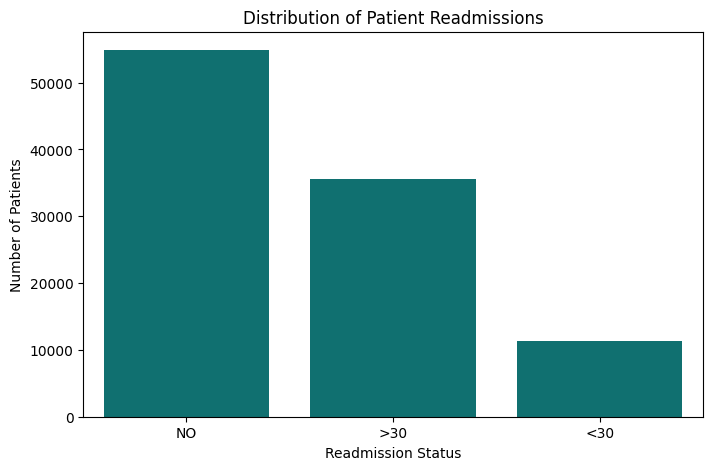

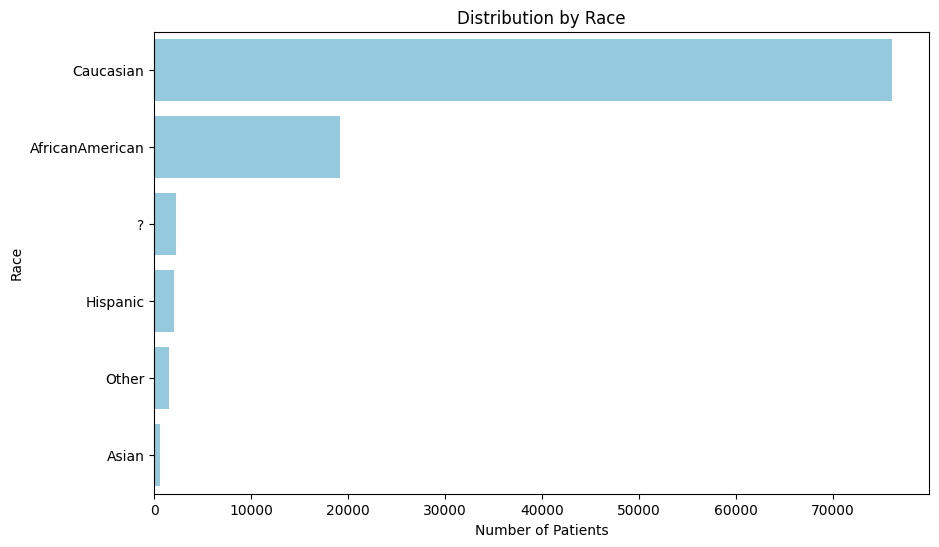

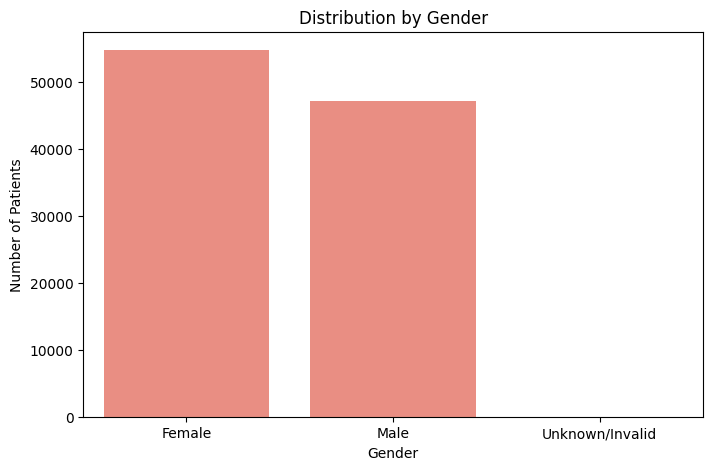

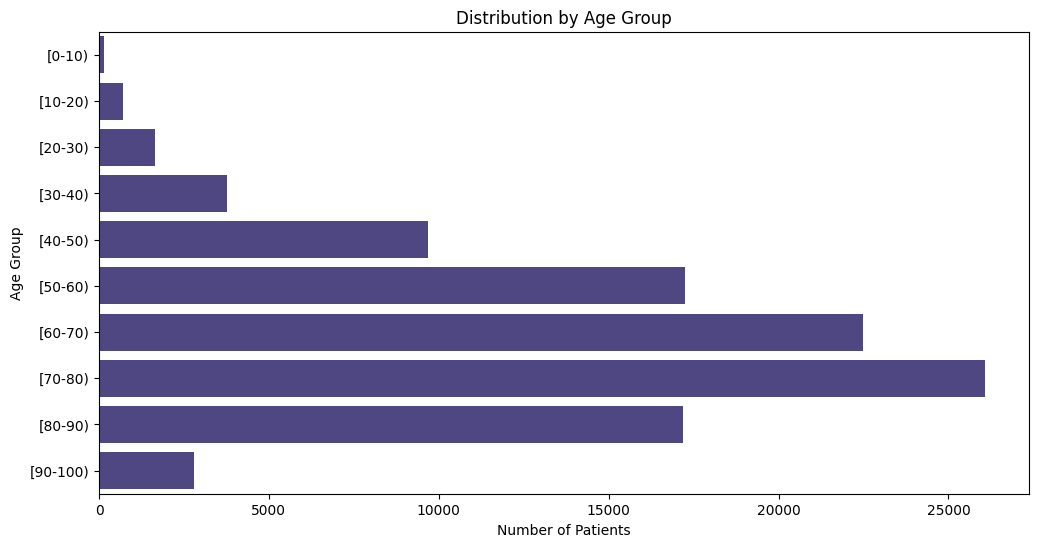

In [ ]:
# --- Countplot for Readmission Status ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='readmitted', order=df['readmitted'].value_counts().index, color='teal')
plt.title('Distribution of Patient Readmissions')
plt.xlabel('Readmission Status')
plt.ylabel('Number of Patients')
plt.show()

# --- Countplot for Race ---
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='race', order=df['race'].value_counts().index, color='skyblue')
plt.title('Distribution by Race')
plt.xlabel('Number of Patients')
plt.ylabel('Race')
plt.show()

# --- Countplot for Gender ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='gender', order=df['gender'].value_counts().index, color='salmon')
plt.title('Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.show()

# --- Countplot for Age ---
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='age', order=sorted(df['age'].unique()), color='darkslateblue')
plt.title('Distribution by Age Group')
plt.xlabel('Number of Patients')
plt.ylabel('Age Group')
plt.show()


C:\Users\kudsit\AppData\Local\Temp\ipykernel_15808\2016686658.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='readmitted', y='time_in_hospital', order=readmission_order, palette='viridis')


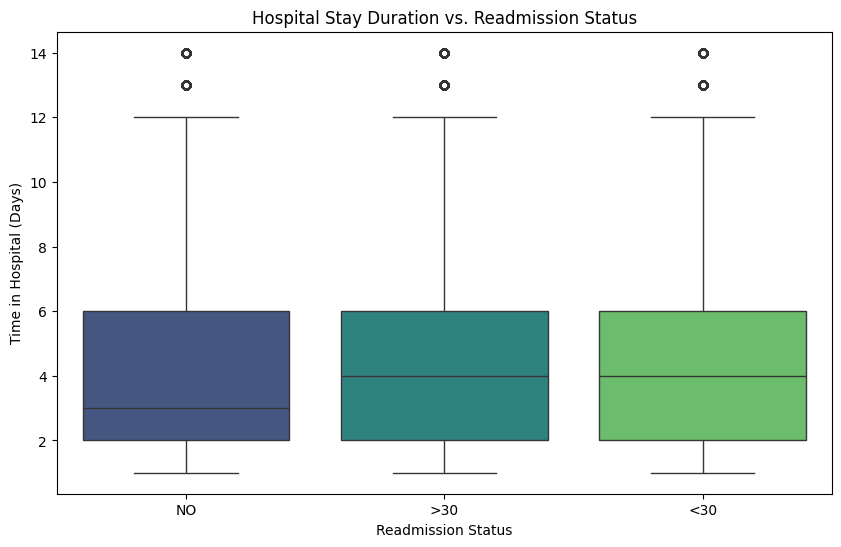

C:\Users\kudsit\AppData\Local\Temp\ipykernel_15808\2016686658.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='readmitted', y='num_lab_procedures', order=readmission_order, palette='plasma')


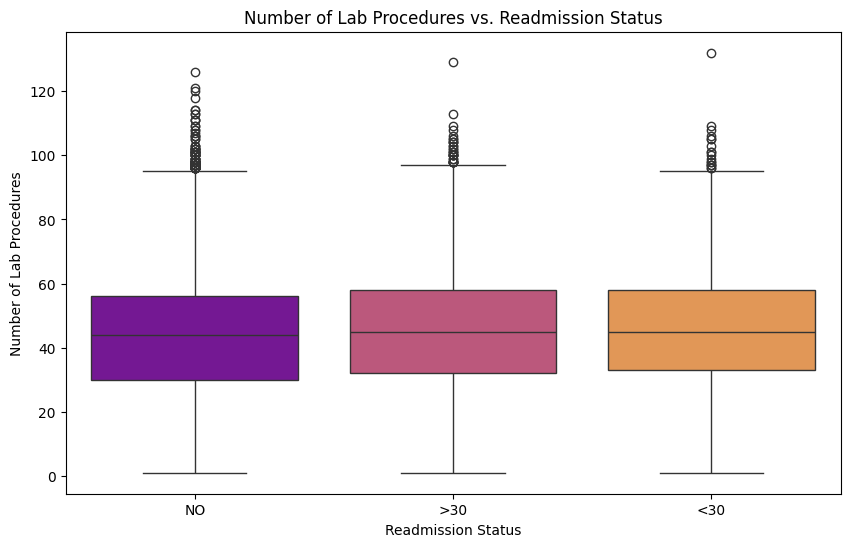

C:\Users\kudsit\AppData\Local\Temp\ipykernel_15808\2016686658.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='readmitted', y='num_medications', order=readmission_order, palette='magma')


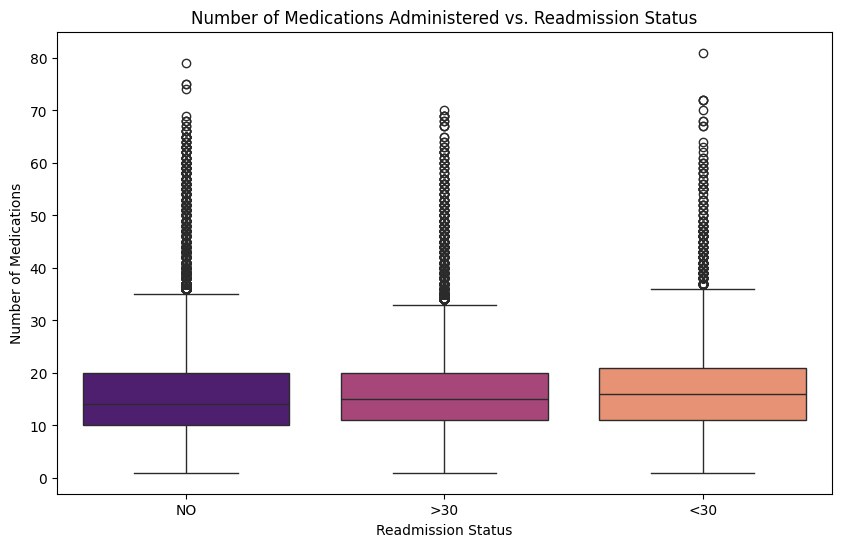

C:\Users\kudsit\AppData\Local\Temp\ipykernel_15808\2016686658.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='readmitted', y='number_diagnoses', order=readmission_order, palette='cividis')


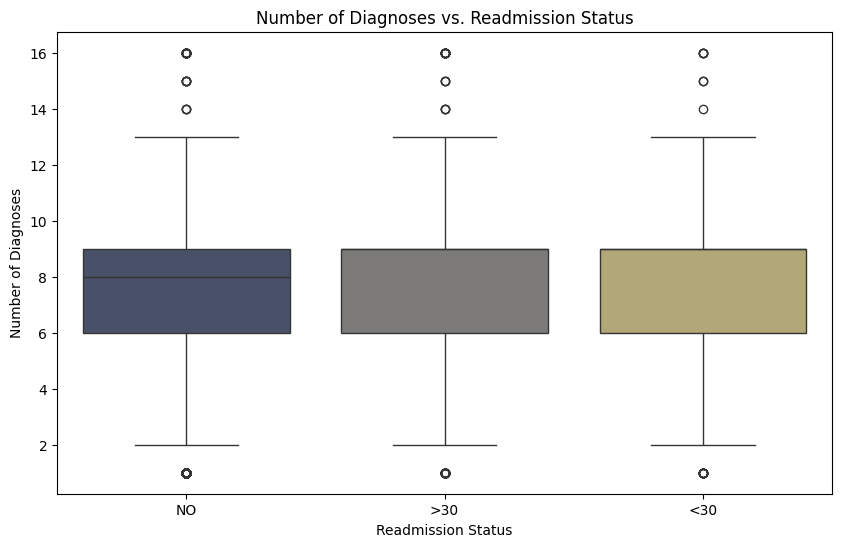

In [24]:
##2. Boxplot

# Define a consistent order for the x-axis
readmission_order = ['NO', '>30', '<30']

# --- Boxplot for Time in Hospital ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='readmitted', y='time_in_hospital', order=readmission_order, palette='viridis')
plt.title('Hospital Stay Duration vs. Readmission Status')
plt.xlabel('Readmission Status')
plt.ylabel('Time in Hospital (Days)')
plt.show()

# --- Boxplot for Number of Lab Procedures ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='readmitted', y='num_lab_procedures', order=readmission_order, palette='plasma')
plt.title('Number of Lab Procedures vs. Readmission Status')
plt.xlabel('Readmission Status')
plt.ylabel('Number of Lab Procedures')
plt.show()

# --- Boxplot for Number of Medications ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='readmitted', y='num_medications', order=readmission_order, palette='magma')
plt.title('Number of Medications Administered vs. Readmission Status')
plt.xlabel('Readmission Status')
plt.ylabel('Number of Medications')
plt.show()

# --- Boxplot for Number of Diagnoses ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='readmitted', y='number_diagnoses', order=readmission_order, palette='cividis')
plt.title('Number of Diagnoses vs. Readmission Status')
plt.xlabel('Readmission Status')
plt.ylabel('Number of Diagnoses')
plt.show()


C:\Users\kudsit\AppData\Local\Temp\ipykernel_15808\2845391809.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='readmitted', y='time_in_hospital', order=readmission_order, palette='crest')


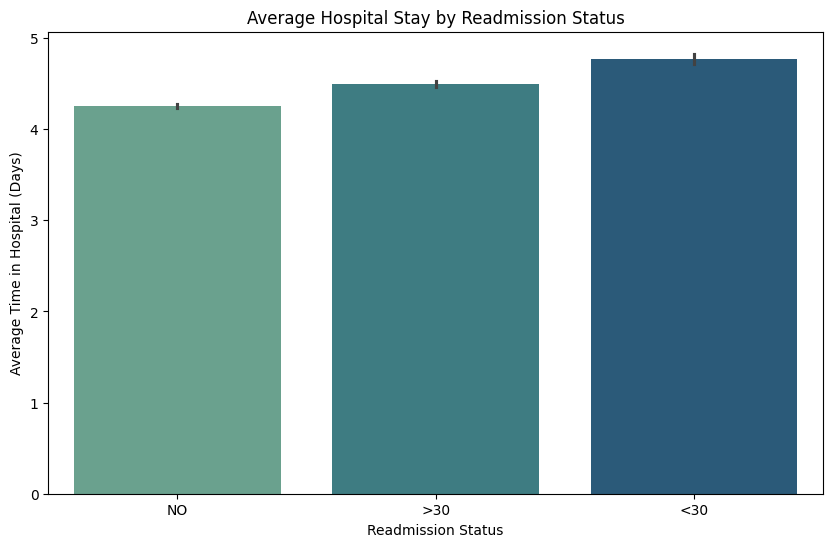

C:\Users\kudsit\AppData\Local\Temp\ipykernel_15808\2845391809.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='readmitted', y='num_medications', order=readmission_order, palette='flare')


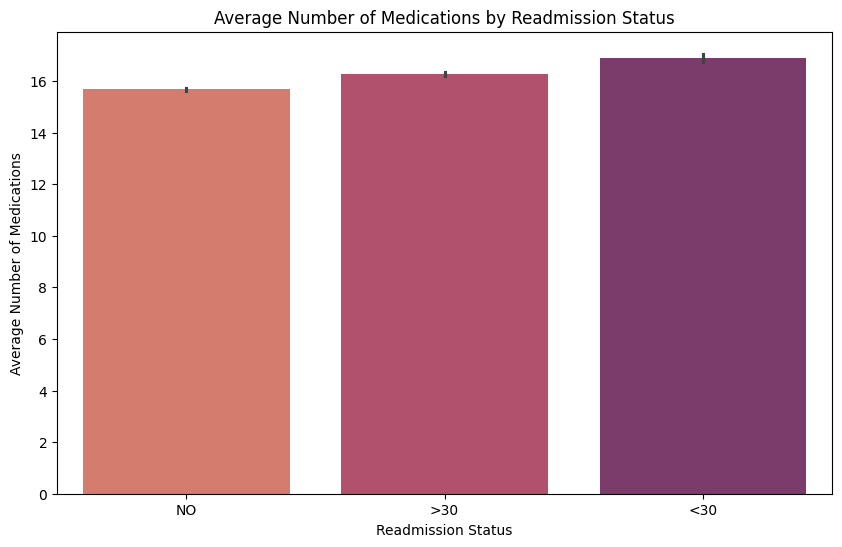

C:\Users\kudsit\AppData\Local\Temp\ipykernel_15808\2845391809.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='age', y='number_diagnoses', order=age_order, palette='cubehelix')


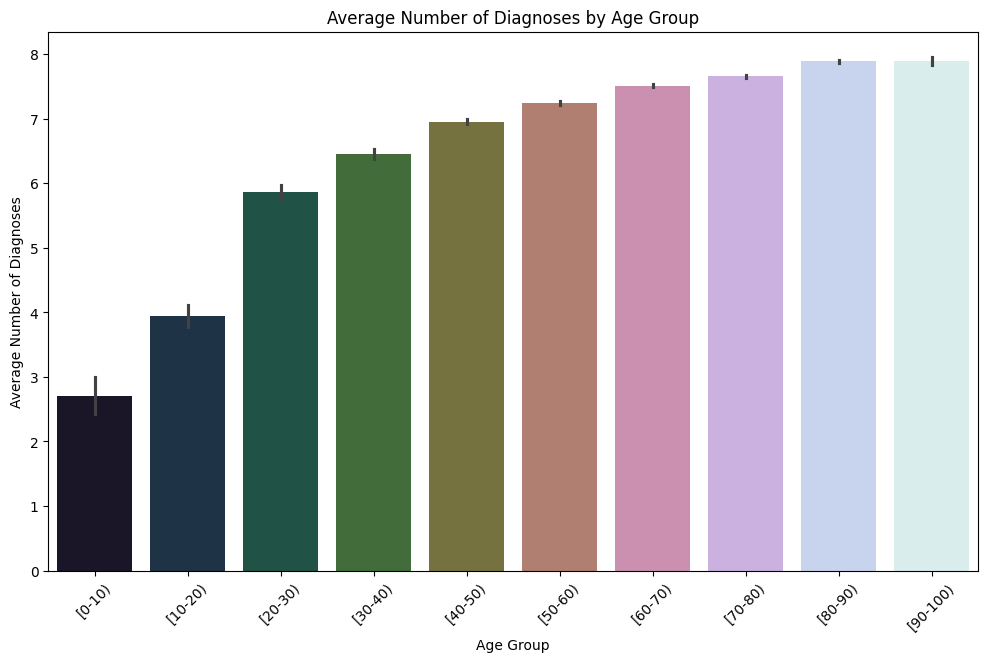

In [25]:
# Define a consistent order for the x-axis
readmission_order = ['NO', '>30', '<30']
age_order = sorted(df['age'].unique())

# --- Barplot of Average Time in Hospital by Readmission Status ---
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='readmitted', y='time_in_hospital', order=readmission_order, palette='crest')
plt.title('Average Hospital Stay by Readmission Status')
plt.xlabel('Readmission Status')
plt.ylabel('Average Time in Hospital (Days)')
plt.show()

# --- Barplot of Average Number of Medications by Readmission Status ---
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='readmitted', y='num_medications', order=readmission_order, palette='flare')
plt.title('Average Number of Medications by Readmission Status')
plt.xlabel('Readmission Status')
plt.ylabel('Average Number of Medications')
plt.show()

# --- Barplot of Average Number of Diagnoses by Age Group ---
plt.figure(figsize=(12, 7))
sns.barplot(data=df, x='age', y='number_diagnoses', order=age_order, palette='cubehelix')
plt.title('Average Number of Diagnoses by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Number of Diagnoses')
plt.xticks(rotation=45) # Rotate x-axis labels for readability
plt.show()


C:\Users\kudsit\AppData\Local\Temp\ipykernel_15808\2488521178.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='readmitted', y='time_in_hospital', order=readmission_order, palette='muted')


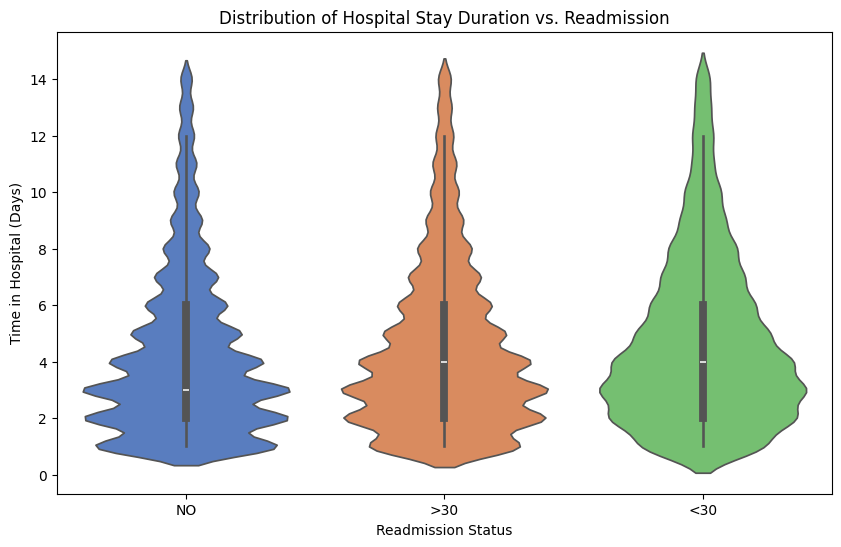

C:\Users\kudsit\AppData\Local\Temp\ipykernel_15808\2488521178.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='readmitted', y='num_lab_procedures', order=readmission_order, palette='pastel')


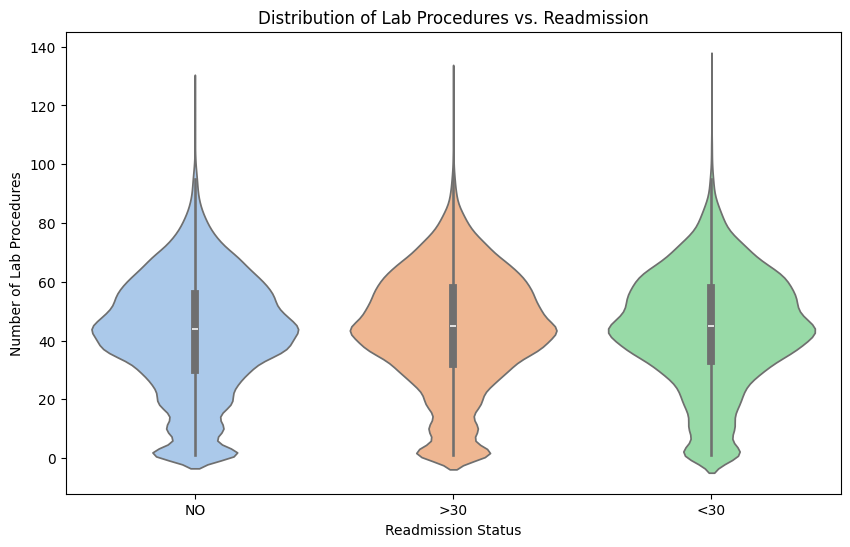

C:\Users\kudsit\AppData\Local\Temp\ipykernel_15808\2488521178.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='readmitted', y='num_medications', order=readmission_order, palette='deep')


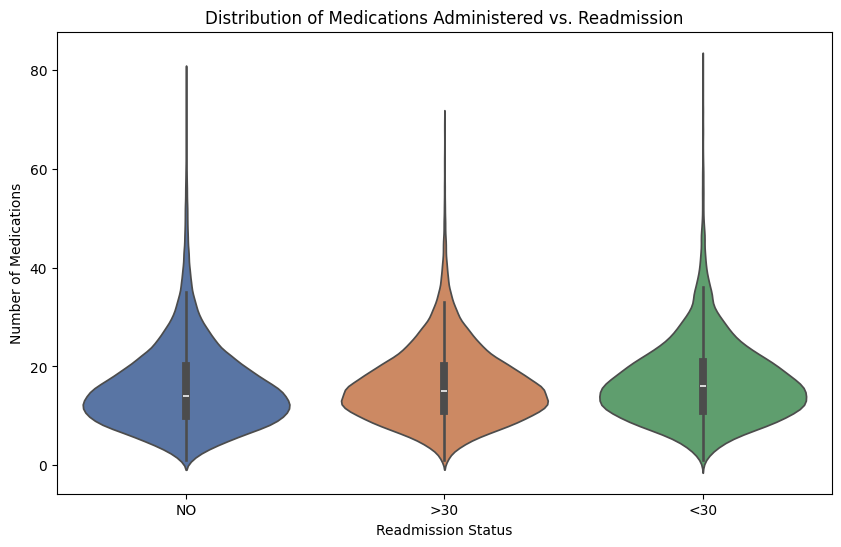

In [26]:
# Define a consistent order for the x-axis
readmission_order = ['NO', '>30', '<30']

# --- Violin Plot for Time in Hospital ---
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='readmitted', y='time_in_hospital', order=readmission_order, palette='muted')
plt.title('Distribution of Hospital Stay Duration vs. Readmission')
plt.xlabel('Readmission Status')
plt.ylabel('Time in Hospital (Days)')
plt.show()

# --- Violin Plot for Number of Lab Procedures ---
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='readmitted', y='num_lab_procedures', order=readmission_order, palette='pastel')
plt.title('Distribution of Lab Procedures vs. Readmission')
plt.xlabel('Readmission Status')
plt.ylabel('Number of Lab Procedures')
plt.show()

# --- Violin Plot for Number of Medications ---
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='readmitted', y='num_medications', order=readmission_order, palette='deep')
plt.title('Distribution of Medications Administered vs. Readmission')
plt.xlabel('Readmission Status')
plt.ylabel('Number of Medications')
plt.show()


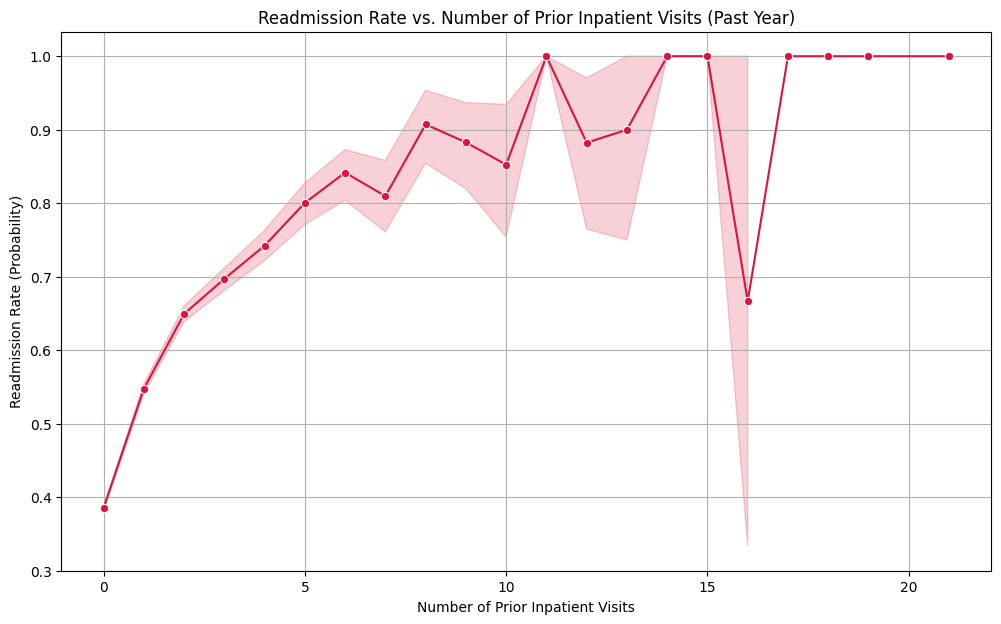

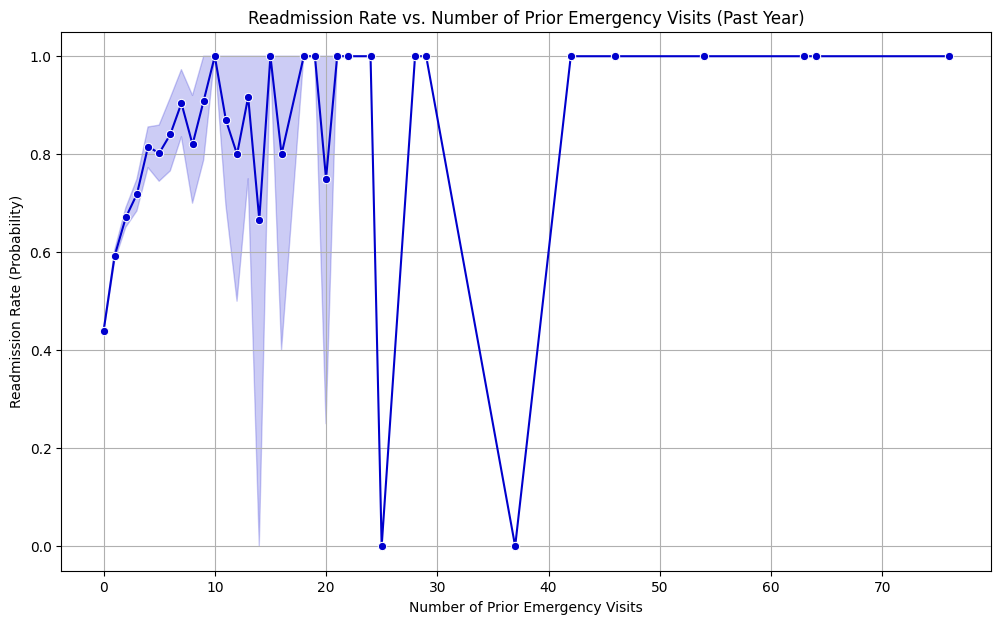

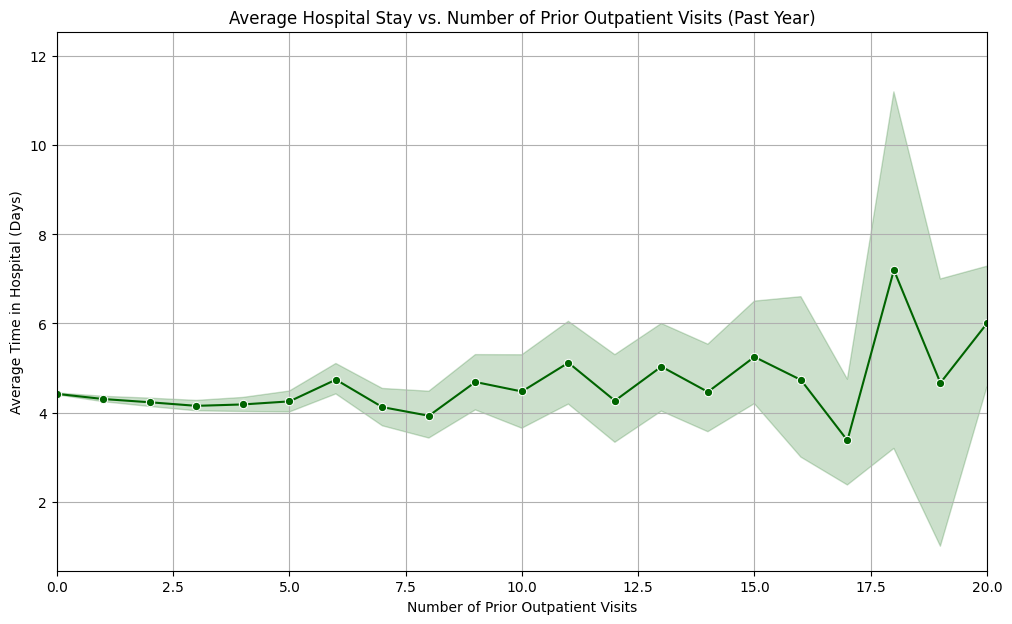

In [27]:
# --- Pre-computation: Create a binary target variable ---
# This makes calculating the readmission rate straightforward.
# We map 'NO' to 0 and both '<30' and '>30' to 1.
df['is_readmitted'] = df['readmitted'].apply(lambda x: 1 if x != 'NO' else 0)


# --- Trend of Readmission Rate by Number of Prior Inpatient Visits ---
plt.figure(figsize=(12, 7))
# A lineplot or pointplot automatically calculates the mean of 'is_readmitted' (the rate) for each 'x' value.
sns.lineplot(data=df, x='number_inpatient', y='is_readmitted', marker='o', color='crimson')
plt.title('Readmission Rate vs. Number of Prior Inpatient Visits (Past Year)')
plt.xlabel('Number of Prior Inpatient Visits')
plt.ylabel('Readmission Rate (Probability)')
plt.grid(True)
plt.show()


# --- Trend of Readmission Rate by Number of Prior Emergency Visits ---
plt.figure(figsize=(12, 7))
sns.lineplot(data=df, x='number_emergency', y='is_readmitted', marker='o', color='mediumblue')
plt.title('Readmission Rate vs. Number of Prior Emergency Visits (Past Year)')
plt.xlabel('Number of Prior Emergency Visits')
plt.ylabel('Readmission Rate (Probability)')
plt.grid(True)
plt.show()


# --- Trend of Average Hospital Stay by Number of Prior Outpatient Visits ---
plt.figure(figsize=(12, 7))
sns.lineplot(data=df, x='number_outpatient', y='time_in_hospital', marker='o', color='darkgreen')
plt.title('Average Hospital Stay vs. Number of Prior Outpatient Visits (Past Year)')
plt.xlabel('Number of Prior Outpatient Visits')
plt.ylabel('Average Time in Hospital (Days)')
plt.grid(True)
plt.xlim(0, 20) # Limit x-axis for better readability as there are long-tail outliers
plt.show()

# Clean up the temporary column if you wish (optional)
del df['is_readmitted']

### 3️⃣ Stage 3️: Data Preprocessing

In [28]:
## Seperating numerical columns 

print("--- Data Preprocessing: Step 1 ---")
print("Separating numerical columns from the main DataFrame.\n")

# Use select_dtypes to automatically identify columns with number-like data types.
numerical_df = df.select_dtypes(include=np.number)

# Get the list of numerical column names
numerical_cols = numerical_df.columns.tolist()

# The 'is_readmitted' column was created for visualization.
# It's a target variable, not a feature, so we should remove it from this list.
if 'is_readmitted' in numerical_cols:
    numerical_cols.remove('is_readmitted')
    # Also drop it from the numerical DataFrame
    numerical_df = numerical_df.drop(columns=['is_readmitted'])

print("Identified Numerical Columns:")
print(numerical_cols)

print("\nShape of the new numerical DataFrame:", numerical_df.shape)
print("\nFirst 5 rows of the numerical DataFrame:")
print(numerical_df.head())

--- Data Preprocessing: Step 1 ---
Separating numerical columns from the main DataFrame.

Identified Numerical Columns:
['admission_type_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

Shape of the new numerical DataFrame: (101766, 10)

First 5 rows of the numerical DataFrame:
   admission_type_id  admission_source_id  time_in_hospital  \
0                  6                    1                 1   
1                  1                    7                 3   
2                  1                    7                 2   
3                  1                    7                 2   
4                  1                    7                 1   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0                  41               0                1                  0   
1                  59               0           

--- Data Preprocessing: Step 2 ---
Checking for outliers in numerical columns.

Counting outliers using the Interquartile Range (IQR) method:
- Column 'admission_type_id': 341 outliers found.
- Column 'admission_source_id': 6956 outliers found.
- Column 'time_in_hospital': 2252 outliers found.
- Column 'num_lab_procedures': 143 outliers found.
- Column 'num_procedures': 4954 outliers found.
- Column 'num_medications': 2557 outliers found.
- Column 'number_outpatient': 16739 outliers found.
- Column 'number_emergency': 11383 outliers found.
- Column 'number_inpatient': 7049 outliers found.
- Column 'number_diagnoses': 281 outliers found.

Visualizing outliers with boxplots...


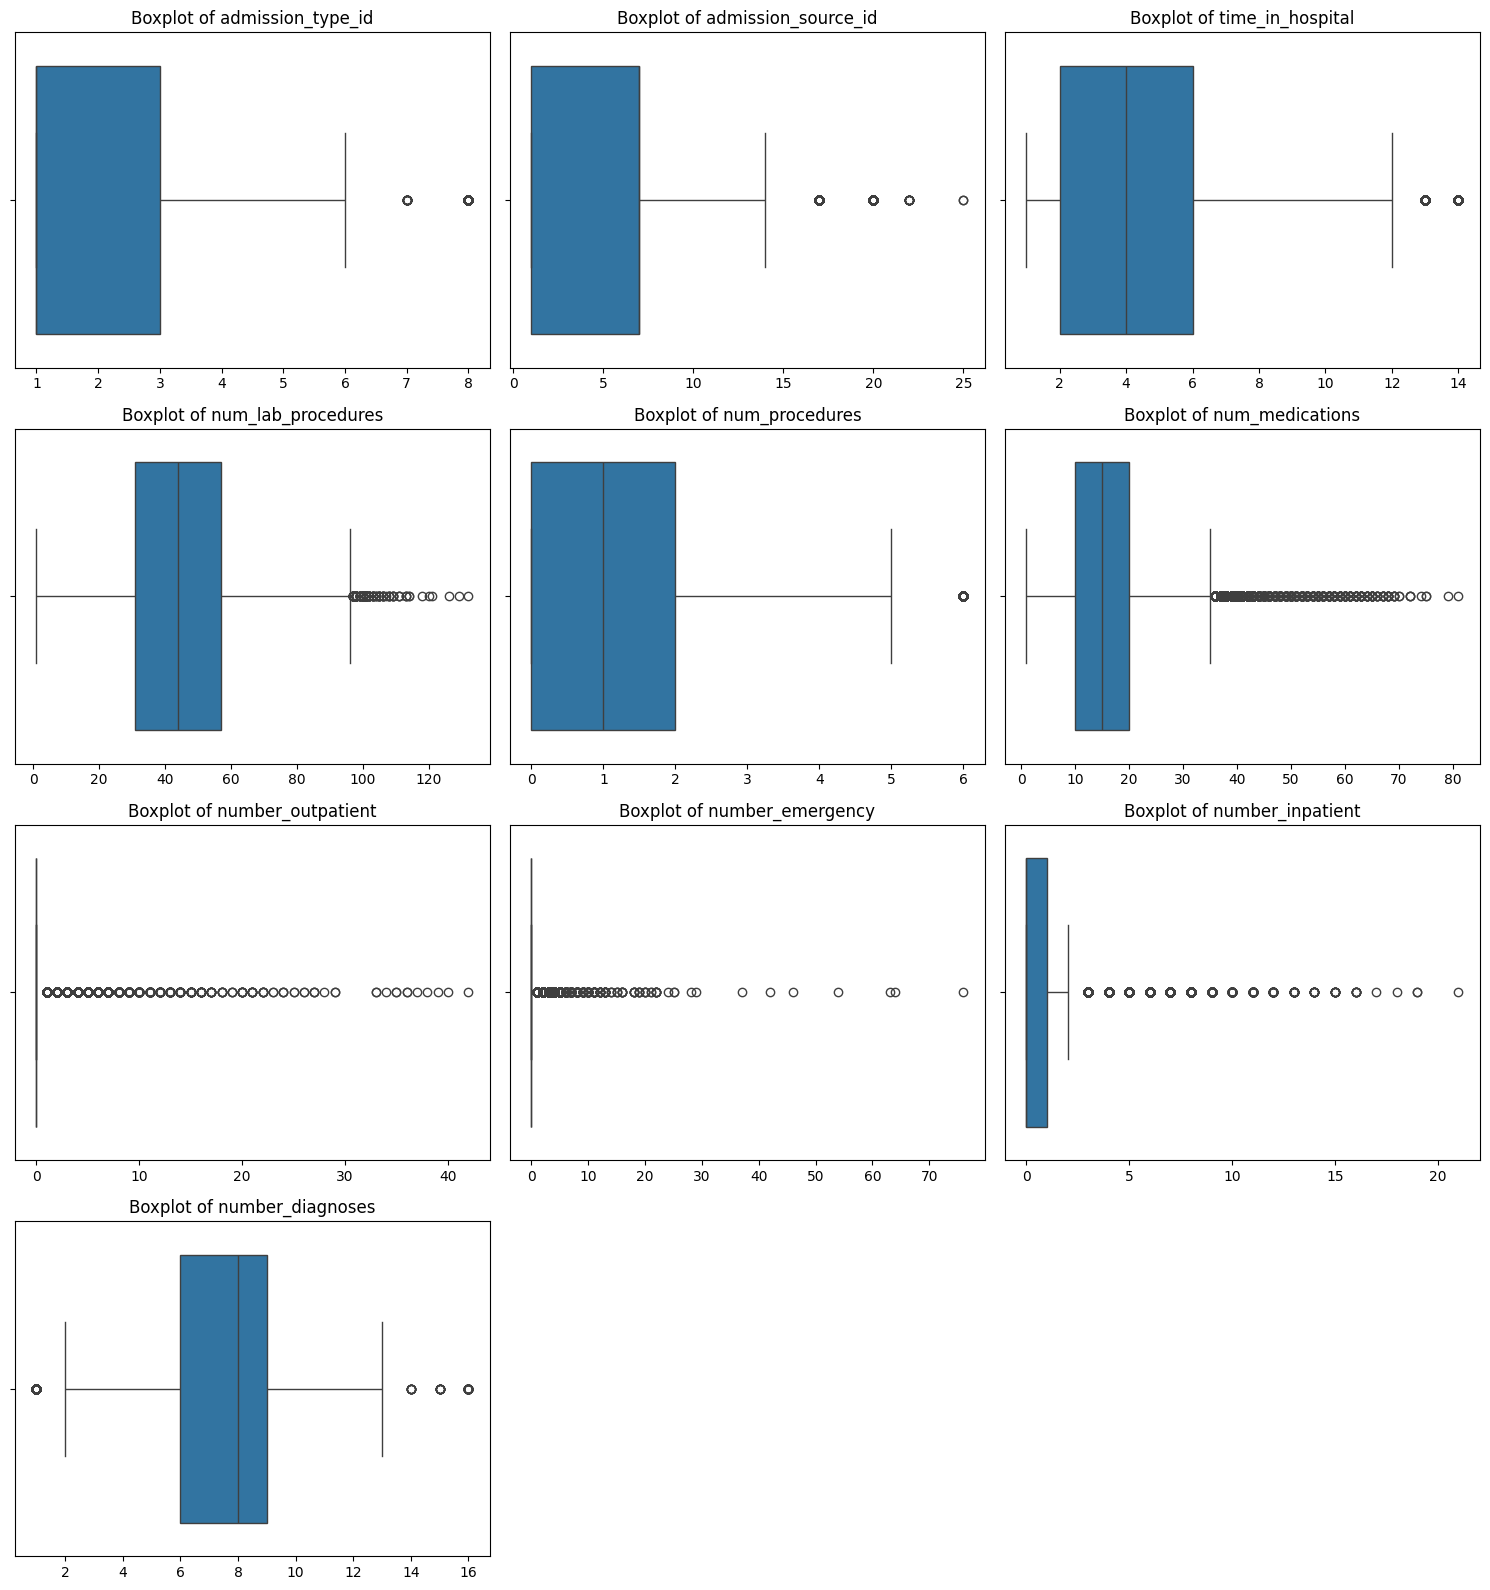

In [29]:
# Assuming 'numerical_df' is your DataFrame from the previous step.

print("--- Data Preprocessing: Step 2 ---")
print("Checking for outliers in numerical columns.\n")


# --- Method 1: Counting Outliers using the IQR Method ---

print("Counting outliers using the Interquartile Range (IQR) method:")

# Loop through each numerical column
for column in numerical_df.columns:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = numerical_df[column].quantile(0.25)
    Q3 = numerical_df[column].quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define the outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify and count the outliers
    outliers = numerical_df[(numerical_df[column] < lower_bound) | (numerical_df[column] > upper_bound)]
    outlier_count = len(outliers)
    
    # Print the result for each column
    if outlier_count > 0:
        print(f"- Column '{column}': {outlier_count} outliers found.")
    else:
        print(f"- Column '{column}': No outliers found.")


# --- Method 2: Visualizing Outliers with Boxplots ---

print("\nVisualizing outliers with boxplots...")

# Set up the matplotlib figure
# We will create a grid of plots to display them all at once
num_cols = len(numerical_df.columns)
num_plot_cols = 3
num_plot_rows = (num_cols + num_plot_cols - 1) // num_plot_cols # Calculate rows needed

fig, axes = plt.subplots(num_plot_rows, num_plot_cols, figsize=(15, num_plot_rows * 4))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Create a boxplot for each numerical column
for i, column in enumerate(numerical_df.columns):
    sns.boxplot(ax=axes[i], x=numerical_df[column])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xlabel('')

# Hide any empty subplots at the end
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

--- Data Preprocessing: Step 3 ---
Capping outliers instead of trimming to preserve data.

- Column 'admission_type_id': Capped 341 outlier values. Outliers remaining: 0.
- Column 'admission_source_id': Capped 6956 outlier values. Outliers remaining: 0.
- Column 'time_in_hospital': Capped 2252 outlier values. Outliers remaining: 0.
- Column 'num_lab_procedures': Capped 143 outlier values. Outliers remaining: 0.
- Column 'num_procedures': Capped 4954 outlier values. Outliers remaining: 0.
- Column 'num_medications': Capped 2557 outlier values. Outliers remaining: 0.
- Column 'number_outpatient': Capped 16739 outlier values. Outliers remaining: 0.
- Column 'number_emergency': Capped 11383 outlier values. Outliers remaining: 0.
- Column 'number_inpatient': Capped 7049 outlier values. Outliers remaining: 0.
- Column 'number_diagnoses': Capped 281 outlier values. Outliers remaining: 0.

Outlier capping complete.

Visualizing boxplots before and after outlier capping...


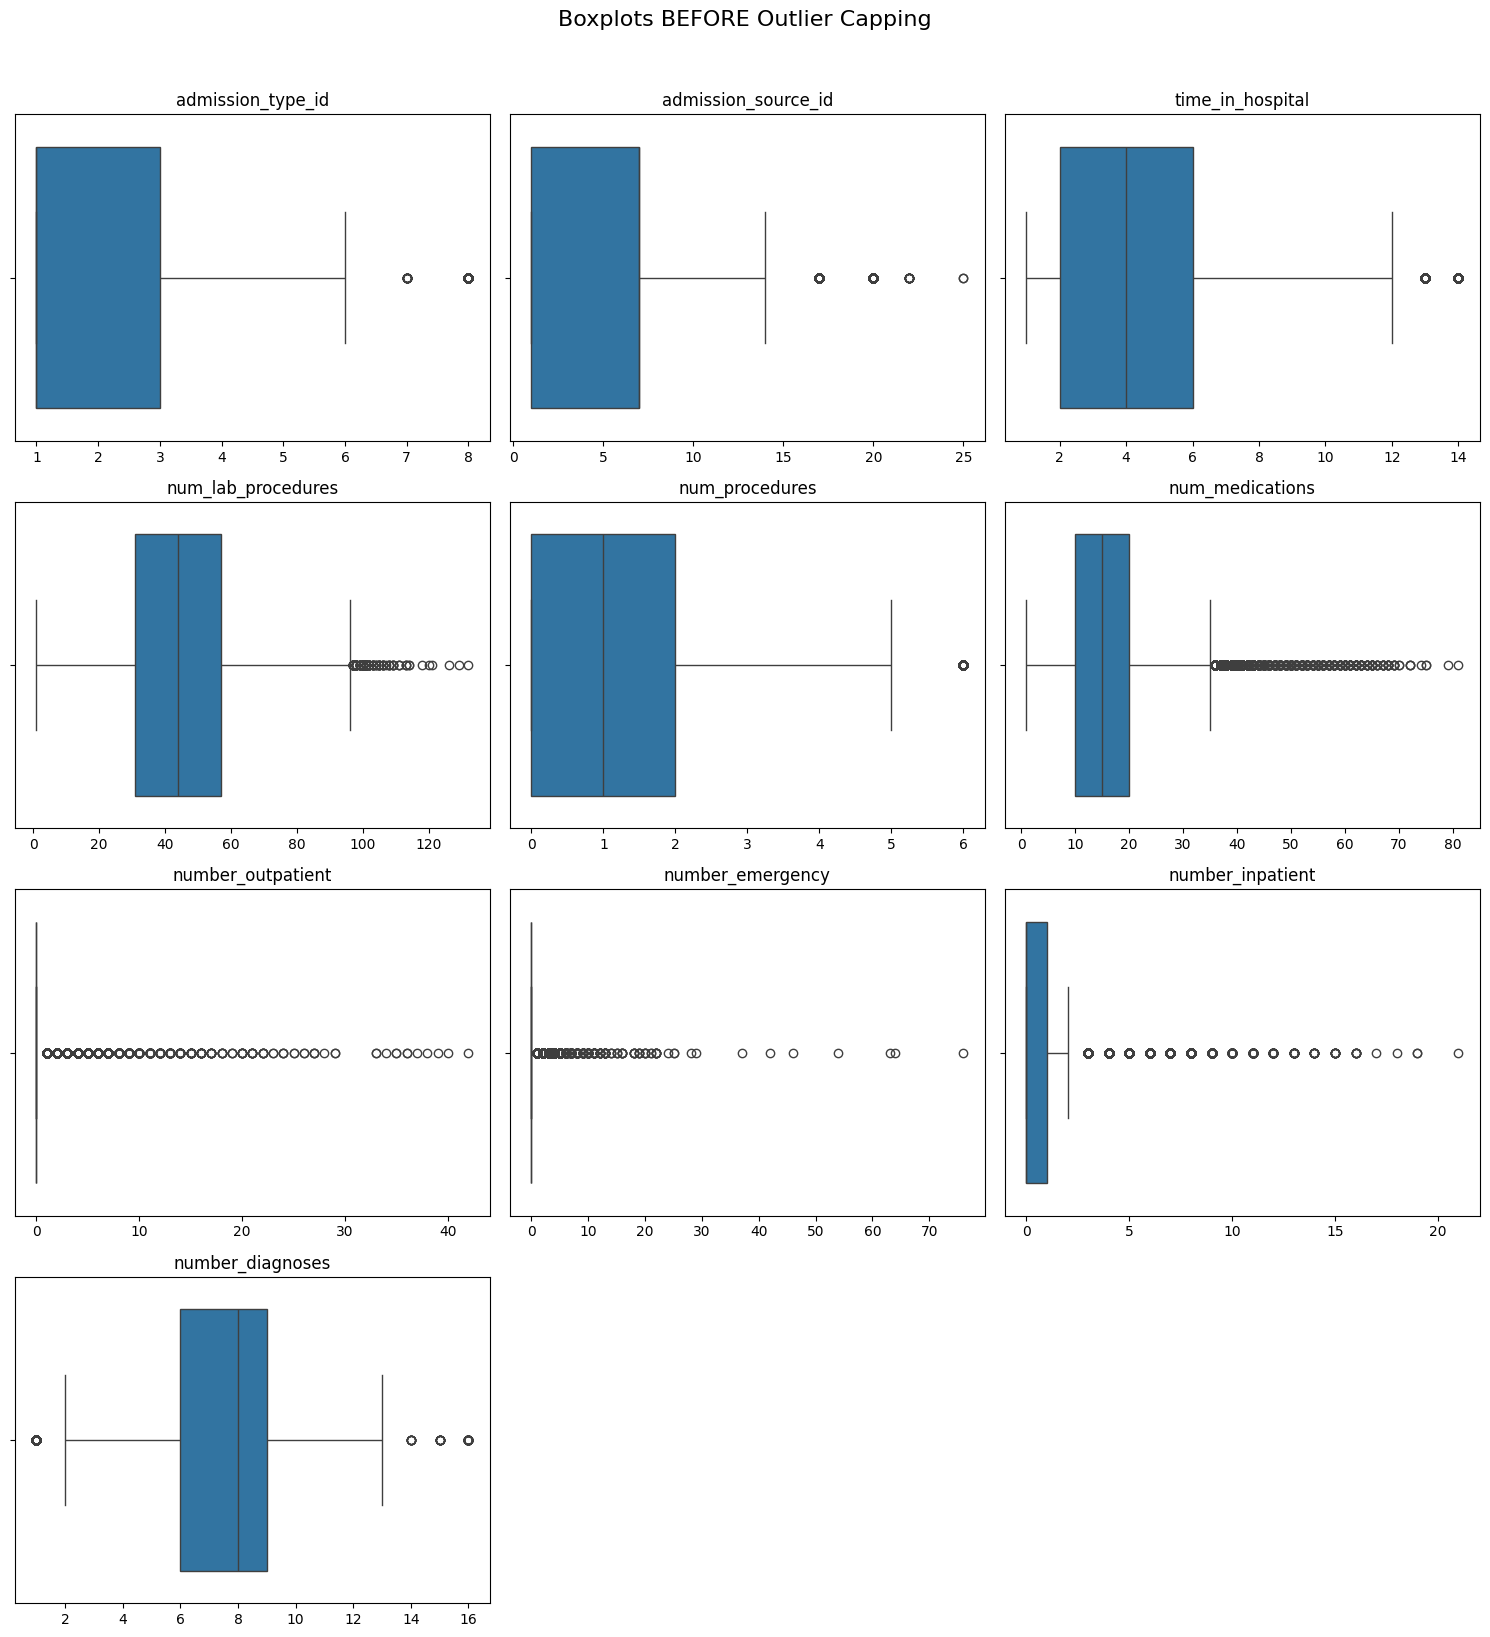

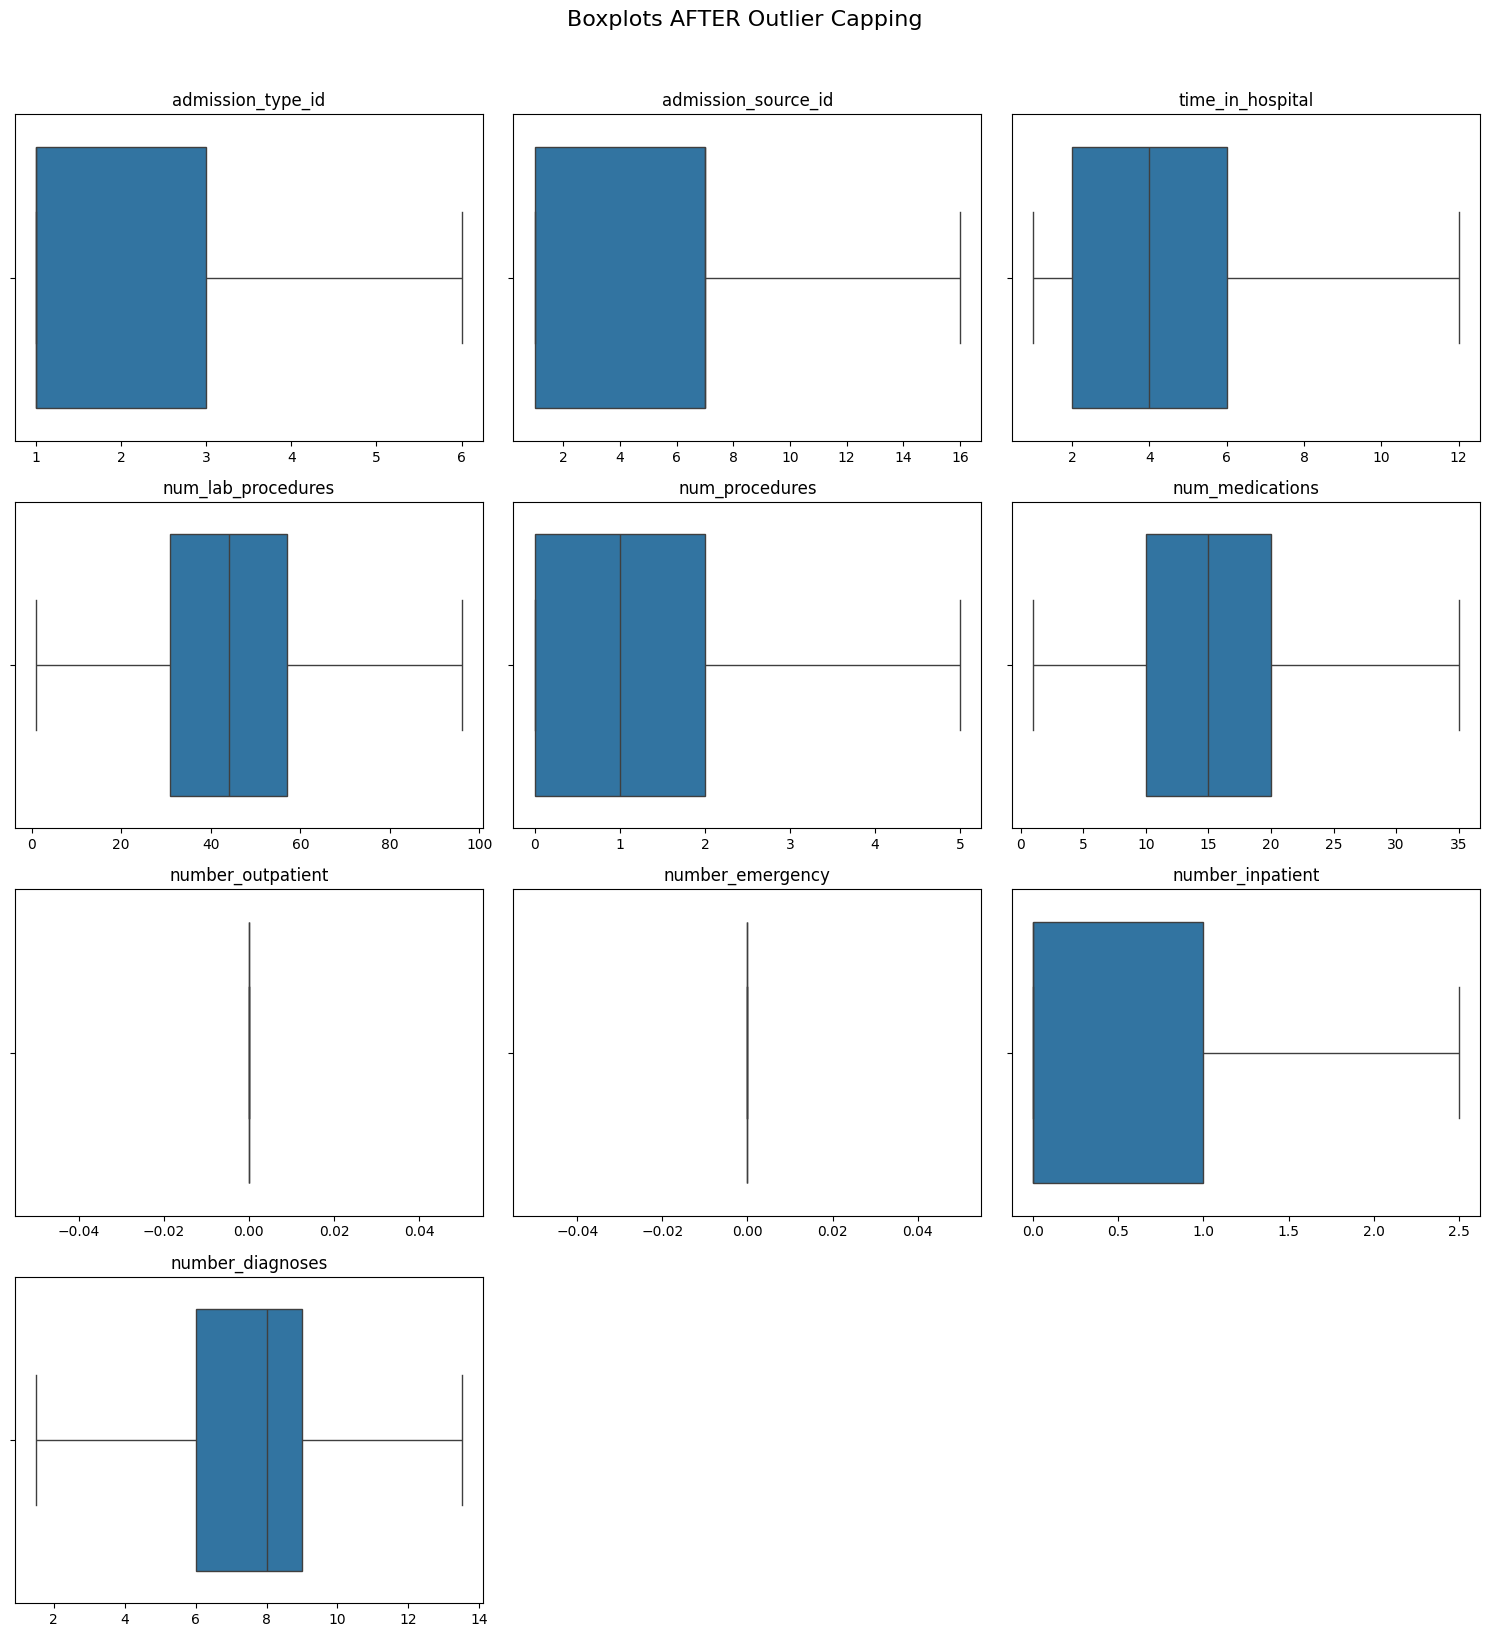

In [30]:
print("--- Data Preprocessing: Step 3 ---")
print("Capping outliers instead of trimming to preserve data.\n")

# Create a copy of the numerical data BEFORE capping for later visualization
numerical_df_before_capping = df[numerical_cols].copy()

# Loop through each numerical column to cap the outliers
for column in numerical_cols:
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before capping
    outliers_before = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
    
    # Cap the outliers
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
    # Count outliers after capping (should be 0)
    outliers_after = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
    
    if outliers_before > 0:
        print(f"- Column '{column}': Capped {outliers_before} outlier values. Outliers remaining: {outliers_after}.")

print("\nOutlier capping complete.")


# --- Visualize the result: Before vs. After Capping ---

print("\nVisualizing boxplots before and after outlier capping...")

# Setup for the plots
num_cols = len(numerical_cols)
num_plot_cols = 3
num_plot_rows = (num_cols + num_plot_cols - 1) // num_plot_cols

# --- Boxplots BEFORE Capping ---
fig, axes = plt.subplots(num_plot_rows, num_plot_cols, figsize=(15, num_plot_rows * 4))
fig.suptitle('Boxplots BEFORE Outlier Capping', fontsize=16, y=1.02)
axes = axes.flatten()

for i, column in enumerate(numerical_cols):
    sns.boxplot(ax=axes[i], x=numerical_df_before_capping[column])
    axes[i].set_title(column)
    axes[i].set_xlabel('')
for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


# --- Boxplots AFTER Capping ---
fig, axes = plt.subplots(num_plot_rows, num_plot_cols, figsize=(15, num_plot_rows * 4))
fig.suptitle('Boxplots AFTER Outlier Capping', fontsize=16, y=1.02)
axes = axes.flatten()

for i, column in enumerate(numerical_cols):
    sns.boxplot(ax=axes[i], x=df[column])
    axes[i].set_title(column)
    axes[i].set_xlabel('')
for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

### Performing  Training and Testing to the dataset and Data Encoding.
#### Converting categorical variables into numerical representations using techniques such as Target encoding, making them suitable for analysis by machine learning algorithms.

In [31]:
print("--- Data Preprocessing: Step 4 ---")
print("Splitting the data into features (X) and a binary target (y).\n")

# 1. Define the features (X)
# X contains all columns EXCEPT the original target 'readmitted' and our temporary 'is_readmitted' column.
features_to_drop = ['readmitted']
if 'is_readmitted' in df.columns:
    features_to_drop.append('is_readmitted')
    
X = df.drop(columns=features_to_drop)

# 2. Define the binary target (y)
# We map 'NO' to 0 and everything else ('<30', '>30') to 1.
y = df['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)


# --- Verification ---
print("--- Features (X) ---")
print("Shape of X:", X.shape)
print("First 5 rows of X:")
print(X.head())

print("\n--- Target (y) ---")
print("Shape of y:", y.shape)
print("First 5 rows of y:")
print(y.head())

print("\nValue counts for the binary target variable (y):")
print(y.value_counts())


--- Data Preprocessing: Step 4 ---
Splitting the data into features (X) and a binary target (y).

--- Features (X) ---
Shape of X: (101766, 43)
First 5 rows of X:
              race  gender      age  admission_type_id  admission_source_id  \
0        Caucasian  Female   [0-10)                  6                    1   
1        Caucasian  Female  [10-20)                  1                    7   
2  AfricanAmerican  Female  [20-30)                  1                    7   
3        Caucasian    Male  [30-40)                  1                    7   
4        Caucasian    Male  [40-50)                  1                    7   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                 1                  41               0                1   
1                 3                  59               0               18   
2                 2                  11               5               13   
3                 2                  44               1   

In [32]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [33]:
X_train

,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
14623,AfricanAmerican,Female,[70-80),6,16,5,48,1,22,0,...,No,No,No,No,No,No,No,No,No,Yes
24966,Caucasian,Male,[50-60),3,1,4,42,3,28,0,...,No,No,Steady,No,No,No,No,No,Ch,Yes
76430,Caucasian,Female,[50-60),1,7,2,12,0,10,0,...,No,No,Steady,No,No,No,No,No,No,Yes
85651,?,Female,[60-70),1,7,4,51,0,15,0,...,No,No,No,No,No,No,No,No,Ch,Yes
87081,Caucasian,Male,[80-90),1,7,9,76,3,35,0,...,No,No,Steady,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47816,Caucasian,Male,[80-90),2,1,11,31,1,10,0,...,No,No,No,No,No,No,No,No,No,No
6775,Caucasian,Male,[70-80),3,1,9,75,2,11,0,...,No,No,No,No,No,No,No,No,No,No
59722,AfricanAmerican,Female,[60-70),5,1,3,51,1,27,0,...,No,No,Up,No,No,No,No,No,Ch,Yes
27121,Caucasian,Female,[70-80),1,7,3,31,0,4,0,...,No,No,No,No,No,No,No,No,No,No


In [34]:
X_test

,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
35956,Caucasian,Female,[70-80),1,6,11,68,0,20,0,...,No,No,Steady,No,No,No,No,No,No,Yes
60927,Caucasian,Male,[50-60),1,1,1,20,0,7,0,...,No,No,No,No,No,No,No,No,No,Yes
79920,Caucasian,Female,[60-70),3,1,4,21,3,23,0,...,No,No,No,No,No,No,No,No,No,Yes
50078,Caucasian,Male,[30-40),2,1,12,28,0,19,0,...,No,No,No,No,No,No,No,No,No,Yes
44080,AfricanAmerican,Female,[60-70),1,7,1,21,0,6,0,...,No,No,No,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16156,Caucasian,Male,[80-90),1,7,6,51,1,17,0,...,No,No,Steady,No,No,No,No,No,No,Yes
67386,Caucasian,Male,[40-50),3,1,2,49,1,16,0,...,No,No,Steady,No,No,No,No,No,Ch,Yes
81342,Caucasian,Female,[70-80),1,7,9,41,2,17,0,...,No,No,No,No,No,No,No,No,No,Yes
72915,Caucasian,Male,[70-80),2,7,2,22,0,5,0,...,No,No,Steady,No,No,No,No,No,No,Yes


In [35]:
y_train

14623    1
24966    1
76430    0
85651    1
87081    0
        ..
47816    0
6775     0
59722    1
27121    0
45617    1
Name: readmitted, Length: 61059, dtype: int64

In [36]:
y_test

35956    0
60927    0
79920    0
50078    1
44080    1
        ..
16156    1
67386    1
81342    1
72915    1
41510    0
Name: readmitted, Length: 20354, dtype: int64

In [37]:
X_val

,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
17198,Caucasian,Female,[50-60),1,7,1,42,0,9,0,...,No,No,Steady,No,No,No,No,No,No,Yes
88553,Caucasian,Female,[60-70),2,1,2,1,1,21,0,...,No,No,No,No,No,No,No,No,No,Yes
2444,AfricanAmerican,Male,[70-80),1,7,2,63,1,10,0,...,No,No,No,No,No,No,No,No,No,Yes
51545,Caucasian,Female,[60-70),1,7,2,39,0,16,0,...,No,No,Up,No,No,No,No,No,Ch,Yes
37422,Caucasian,Female,[70-80),3,1,1,44,0,16,0,...,No,No,Steady,No,No,No,No,No,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16542,Caucasian,Male,[70-80),1,7,7,49,0,17,0,...,No,No,Steady,No,No,No,No,No,Ch,Yes
67099,Caucasian,Female,[90-100),2,7,3,47,0,7,0,...,No,No,Steady,No,No,No,No,No,No,Yes
49381,Caucasian,Female,[50-60),1,7,11,59,1,32,0,...,No,No,No,No,No,No,No,No,No,No
4266,Caucasian,Female,[70-80),1,7,3,42,0,4,0,...,No,No,Steady,No,No,No,No,No,Ch,Yes


In [38]:
y_val

17198    1
88553    0
2444     0
51545    1
37422    1
        ..
16542    1
67099    1
49381    1
4266     0
91791    0
Name: readmitted, Length: 20353, dtype: int64

In [40]:
print("--- Data Preprocessing: Step 5 ---")
print("Encoding categorical features.\n")

# --- 5.1: Clean Missing Categorical Values ---
print("--- 5.1: Cleaning '?' and 'Unknown/Invalid' values ---")

# Replace '?' in 'race' with the mode
race_mode = X['race'].mode()[0]
X['race'] = X['race'].replace('?', race_mode)
print(f"Replaced '?' in 'race' column with mode: '{race_mode}'")

# Replace 'Unknown/Invalid' in 'gender' with the mode
gender_mode = X['gender'].mode()[0]
X['gender'] = X['gender'].replace('Unknown/Invalid', gender_mode)
print(f"Replaced 'Unknown/Invalid' in 'gender' column with mode: '{gender_mode}'")

# For diagnosis columns, '?' means no diagnosis was recorded. We'll treat it as its own category.
for col in ['diag_1', 'diag_2', 'diag_3']:
    X[col] = X[col].replace('?', 'Not_Recorded')
print("Replaced '?' in diagnosis columns with 'Not_Recorded'.\n")


# --- 5.2: Ordinal Encoding ---
print("--- 5.2: Applying Ordinal Encoding ---")

# Define the order for the 'age' column
age_order = sorted(X['age'].unique())
age_map = {val: i for i, val in enumerate(age_order)}

# Define the order for medication columns
med_map = {'No': 0, 'Down': 1, 'Steady': 2, 'Up': 3}

# Apply mapping to 'age'
X['age'] = X['age'].map(age_map)
print("Applied Ordinal Encoding to 'age' column.")

# Apply mapping to all medication columns
med_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
            'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
            'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin',
            'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
            'metformin-rosiglitazone', 'metformin-pioglitazone']

# Some columns like 'examide' and 'citoglipton' have only 'No', we will drop them as they provide no information
cols_to_drop_no_variance = [col for col in med_cols if X[col].nunique() == 1]
X.drop(columns=cols_to_drop_no_variance, inplace=True)
print(f"Dropped medication columns with no variance: {cols_to_drop_no_variance}")

# Update med_cols list
med_cols = [col for col in med_cols if col not in cols_to_drop_no_variance]

for col in med_cols:
    X[col] = X[col].map(med_map)
print("Applied Ordinal Encoding to medication columns.\n")


# --- 5.3: Feature Engineering for Diagnosis Codes ---
print("--- 5.3: Grouping Diagnosis Codes into Categories ---")

# Replace non-numeric characters in diagnosis codes
for col in ['diag_1', 'diag_2', 'diag_3']:
    X[col] = X[col].str.replace('E', '').str.replace('V', '')
    X[col] = X[col].replace('Not_Recorded', np.nan) # Temporarily set to NaN for numeric conversion
    X[col] = pd.to_numeric(X[col], errors='coerce')

def group_diagnosis(code):
    if pd.isna(code): return 'Not_Recorded'
    code = float(code)
    if (code >= 390 and code <= 459) or code == 785: return 'Circulatory'
    if (code >= 460 and code <= 519) or code == 786: return 'Respiratory'
    if (code >= 520 and code <= 579) or code == 787: return 'Digestive'
    if code >= 250 and code < 251: return 'Diabetes'
    if code >= 800 and code <= 999: return 'Injury'
    if code >= 710 and code <= 739: return 'Musculoskeletal'
    if (code >= 580 and code <= 629) or code == 788: return 'Genitourinary'
    if code >= 140 and code <= 239: return 'Neoplasms'
    return 'Other'

X['diag_1_group'] = X['diag_1'].apply(group_diagnosis)
X['diag_2_group'] = X['diag_2'].apply(group_diagnosis)
X['diag_3_group'] = X['diag_3'].apply(group_diagnosis)

# Drop the original high-cardinality diagnosis columns
X.drop(columns=['diag_1', 'diag_2', 'diag_3'], inplace=True)
print("Grouped diagnosis codes and dropped original columns.\n")


# --- 5.4: One-Hot Encoding ---
print("--- 5.4: Applying One-Hot Encoding ---")

# Identify remaining object columns to be one-hot encoded
categorical_cols_to_ohe = X.select_dtypes(include='object').columns.tolist()
print(f"Columns to be One-Hot Encoded: {categorical_cols_to_ohe}")

# Use pandas.get_dummies for simplicity
X = pd.get_dummies(X, columns=categorical_cols_to_ohe, drop_first=True)
print("One-Hot Encoding complete.")


# --- Verification ---
print("\n--- Final Features (X) after Encoding ---")
print("Shape of X:", X.shape)
print("\nData types of columns in X:")
X.info()
print("\nFirst 5 rows of the fully processed X:")
print(X.head())

--- Data Preprocessing: Step 5 ---
Encoding categorical features.

--- 5.1: Cleaning '?' and 'Unknown/Invalid' values ---
Replaced '?' in 'race' column with mode: 'Caucasian'
Replaced 'Unknown/Invalid' in 'gender' column with mode: 'Female'
Replaced '?' in diagnosis columns with 'Not_Recorded'.

--- 5.2: Applying Ordinal Encoding ---
Applied Ordinal Encoding to 'age' column.
Dropped medication columns with no variance: ['examide', 'citoglipton']
Applied Ordinal Encoding to medication columns.

--- 5.3: Grouping Diagnosis Codes into Categories ---
Grouped diagnosis codes and dropped original columns.

--- 5.4: Applying One-Hot Encoding ---
Columns to be One-Hot Encoded: ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'diag_1_group', 'diag_2_group', 'diag_3_group']
One-Hot Encoding complete.

--- Final Features (X) after Encoding ---
Shape of X: (101766, 70)

Data types of columns in X:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 10176

#### Feature Scaling:

#### After the process of encoding, we perform the scaling of the features using standardscaler or minmaxscale on numerical columns

In [41]:
print("--- Data Preprocessing: Step 6 ---")
print("Scaling numerical features using StandardScaler.\n")

# 1. Identify all columns that need to be scaled.
# This includes the original numerical columns and the ordinally encoded ones.
cols_to_scale = numerical_cols + ['age'] + med_cols

# Let's ensure no columns are missing or incorrect
# This filters out any columns that might have been dropped (e.g., meds with no variance)
cols_to_scale = [col for col in cols_to_scale if col in X.columns]

print(f"Columns to be scaled ({len(cols_to_scale)} total):")
print(cols_to_scale)

# 2. Initialize the scaler
scaler = StandardScaler()

# 3. Fit the scaler to the specified columns and transform them.
# This replaces the original values with the scaled values in the DataFrame.
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

print("\nScaling complete.")

# --- Verification ---
print("\n--- Final Features (X) after Scaling ---")
print("Shape of X:", X.shape)

print("\nVerifying the scaled data (showing first 5 rows):")
# Display the head, but include a mix of scaled and unscaled columns for comparison
display_cols = numerical_cols[:3] + ['age'] + [col for col in X.columns if 'race' in col][:2]
print(X[display_cols].head())

print("\nDescription of scaled 'time_in_hospital' column (should have mean ~0, std dev ~1):")
print(X['time_in_hospital'].describe())

--- Data Preprocessing: Step 6 ---
Scaling numerical features using StandardScaler.

Columns to be scaled (32 total):
['admission_type_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

Scaling complete.

--- Final Features (X) after Scaling ---
Shape of X: (101766, 70)

Verifying the scaled data (showing first 5 rows):
   admission_type_id  admission_source_id  time_in_hospital       age  \
0           2.798821            -1.212565         -1.163010 -3.824600   
1          -0.715088        

In [42]:
# Adding a validation set is a best practice in machine learning, as it allows you to tune your model's hyperparameters without "contaminating" your final test set.

print("--- Data Preprocessing: Step 7 (Revised) ---")
print("Splitting the data into training, validation, and testing sets (60/20/20).\n")

# Step 7.1: First split to separate the final test set (20%)
# This creates a temporary training set (80%) and the final test set (20%).
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% of data goes to the final test set
    random_state=42,
    stratify=y
)

# Step 7.2: Second split on the temporary training set to create the final training and validation sets
# We want validation to be 20% of the *original* data. Since X_temp is 80% of the original,
# we need to take 25% of X_temp to get our 20% validation set (0.25 * 0.80 = 0.20).
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,      # 25% of the temporary set (which is 20% of the original data)
    random_state=42,
    stratify=y_temp
)


# --- Verification ---
print("--- Shapes of the resulting datasets ---")
print(f"Training Set:   X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Validation Set: X_val shape:   {X_val.shape},   y_val shape:   {y_val.shape}")
print(f"Testing Set:    X_test shape:  {X_test.shape},  y_test shape:  {y_test.shape}")

print("\n--- Distribution of target variable across sets ---")
print("Original y distribution:\n", y.value_counts(normalize=True))
print("\ny_train distribution:\n", y_train.value_counts(normalize=True))
print("\ny_val distribution:\n", y_val.value_counts(normalize=True))
print("\ny_test distribution:\n", y_test.value_counts(normalize=True))

--- Data Preprocessing: Step 7 (Revised) ---
Splitting the data into training, validation, and testing sets (60/20/20).

--- Shapes of the resulting datasets ---
Training Set:   X_train shape: (61059, 70), y_train shape: (61059,)
Validation Set: X_val shape:   (20353, 70),   y_val shape:   (20353,)
Testing Set:    X_test shape:  (20354, 70),  y_test shape:  (20354,)

--- Distribution of target variable across sets ---
Original y distribution:
 readmitted
0    0.539119
1    0.460881
Name: proportion, dtype: float64

y_train distribution:
 readmitted
0    0.539118
1    0.460882
Name: proportion, dtype: float64

y_val distribution:
 readmitted
0    0.539134
1    0.460866
Name: proportion, dtype: float64

y_test distribution:
 readmitted
0    0.539108
1    0.460892
Name: proportion, dtype: float64


### 4️⃣ Stage 4: Model Building and Evaluation 

#### 📌 Model Building Approach

To build a robust and accurate predictive model, several classification algorithms will be implemented and compared. The selected models offer a diverse range of learning approaches, including linear models, a single tree-based model, and powerful ensemble methods.

The following models from the scikit-learn library will be used:

**Logistic Regression** 
A fundamental linear model for binary classification, used to establish a baseline performance.

**Decision Tree Classifier**
A non-linear model that splits data into branches to create interpretable decision rules, though it is often prone to overfitting.

**Random Forest Classifier**
An ensemble method that builds multiple decision trees and merges their predictions to improve accuracy and control for overfitting.

**Linear Support Vector Classifier (LinearSVC)**
A Support Vector Machine with a linear kernel, which is highly effective in high-dimensional spaces and memory-efficient for datasets with many features.

**HistGradientBoosting Classifier**
A fast and efficient gradient boosting algorithm that is highly suitable for large datasets. It uses histogram-based techniques to speed up training and reduce memory usage.

Each model will be trained on the training data and evaluated on the validation set. Key classification metrics, such as Accuracy and F1-Score, will be used to compare their performance and identify the best-performing model for predicting patient readmission.

In [ ]:
# --- 8.1: Model Training and Evaluation (on Validation Set) ---

# Define the classification models
models = {
    # Increased max_iter for convergence on this dataset
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000), 
    "Decision Tree": DecisionTreeClassifier(random_state=42), 
    # n_jobs=-1 uses all available CPU cores for faster training
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1), 
    # LinearSVC is much faster than SVC(kernel='linear') for large datasets
    "Linear SVM (SVC)": LinearSVC(random_state=42, max_iter=5000, dual=False), # dual=False is recommended when n_samples > n_features
    # A highly efficient gradient boosting model for large datasets
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42) 
}

# Create a list to store the results
results = []

print("--- Starting Model Training and Evaluation (on Validation Set) ---")

# Loop through each model
for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    
    # --- Fit the model ---
    # The data (X_train, y_train) is already preprocessed and scaled, so we fit directly.
    model.fit(X_train, y_train)
    
    end_time = time.time()
    train_time = end_time - start_time
    
    # --- Evaluate on the VALIDATION set ---
    y_pred_val = model.predict(X_val)
    
    # Calculate classification metrics
    accuracy = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average='weighted') 
    
    # Append the results to our list
    results.append({
        "Model": name,
        "Train Time (s)": round(train_time, 4),
        "Accuracy (Val)": round(accuracy, 4),
        "F1 Score (Val)": round(f1, 4)
    })

print("\n--- Evaluation Complete ---")

# --- 8.2: Display Results ---

# Convert the results list to a DataFrame and sort by accuracy
results_df = pd.DataFrame(results).sort_values(by="Accuracy (Val)", ascending=False)

print("\nModel Performance Comparison (on Validation Set) - Patient Readmission Prediction:")
print(results_df.to_markdown(index=False, numalign="left", stralign="left"))

--- Starting Model Training and Evaluation (on Validation Set) ---
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Linear SVM (SVC)...
Training HistGradientBoosting...

--- Evaluation Complete ---

Model Performance Comparison (on Validation Set) - Patient Readmission Prediction:
| Model                | Train Time (s)   | Accuracy (Val)   | F1 Score (Val)   |
|:---------------------|:-----------------|:-----------------|:-----------------|
| HistGradientBoosting | 0.7157           | 0.6278           | 0.6214           |
| Random Forest        | 1.2252           | 0.619            | 0.6133           |
| Linear SVM (SVC)     | 1.5842           | 0.6173           | 0.6025           |
| Logistic Regression  | 0.3022           | 0.617            | 0.6031           |
| Decision Tree        | 0.7154           | 0.5432           | 0.5433           |


### 5️⃣ Stage 5 :Hyperparameter Tuning with Randomized Search CV

In [47]:
print("--- Step 9: Hyperparameter Tuning for Random Forest ---")

# --- 9.1: Define the Hyperparameter Grid ---
# We are creating a distribution of parameters to sample from.
param_dist = {
    'n_estimators': [100, 200, 300, 500], # Number of trees in the forest
    'max_depth': [10, 20, 30, None], # Maximum depth of the tree (None means nodes are expanded until all leaves are pure)
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'] # Number of features to consider when looking for the best split
}

print("Defined hyperparameter distribution for Randomized Search.\n")

# --- 9.2: Set up and Run Randomized Search CV ---
# Initialize the base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Initialize RandomizedSearchCV
# n_iter: Number of parameter settings that are sampled.
# cv: Number of cross-validation folds. 3 is a good balance for speed on large datasets.
# scoring: The metric to optimize for. 'f1_weighted' is robust for imbalanced classes.
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Try 50 different combinations
    cv=3,
    scoring='f1_weighted',
    verbose=1,  # Set to 2 to see more details
    random_state=42,
    n_jobs=-1   # Use all available CPU cores
)

print("Starting Randomized Search CV... (This may take several minutes)")
start_time = time.time()

# Fit the random search model on the training data
random_search.fit(X_train, y_train)

end_time = time.time()
print(f"\nRandomized Search CV completed in { (end_time - start_time) / 60:.2f} minutes.")


# --- 9.3: Identify the Best Model and Parameters ---
print("\n--- Tuning Results ---")
print("Best Hyperparameters found:")
print(random_search.best_params_)

print(f"\nBest cross-validated F1-Score (on training data): {random_search.best_score_:.4f}")

# The 'best_estimator_' is the model already refit on the full training data with the best parameters found.
best_tuned_rf = random_search.best_estimator_


# --- 9.4: Evaluate the Fine-Tuned Model on the Validation Set ---
print("\n--- Evaluating Fine-Tuned Model Performance ---")

# Make predictions on the validation set
y_pred_val_tuned = best_tuned_rf.predict(X_val)

# Calculate new performance metrics
accuracy_tuned = accuracy_score(y_val, y_pred_val_tuned)
f1_tuned = f1_score(y_val, y_pred_val_tuned, average='weighted')

print(f"Tuned Random Forest - Accuracy (Val): {accuracy_tuned:.4f}")
print(f"Tuned Random Forest - F1 Score (Val): {f1_tuned:.4f}")


# --- Compare with the baseline model from Step 8 ---
# (Assuming 'results_df' from the previous step is available)
baseline_rf_metrics = results_df[results_df['Model'] == 'Random Forest'].iloc[0]

comparison_data = {
    'Model': ['Baseline Random Forest', 'Tuned Random Forest'],
    'Accuracy (Val)': [baseline_rf_metrics['Accuracy (Val)'], accuracy_tuned],
    'F1 Score (Val)': [baseline_rf_metrics['F1 Score (Val)'], f1_tuned]
}
comparison_df = pd.DataFrame(comparison_data)

print("\n--- Performance Comparison ---")
print(comparison_df.to_markdown(index=False, numalign="left", stralign="left"))

--- Step 9: Hyperparameter Tuning for Random Forest ---
Defined hyperparameter distribution for Randomized Search.

Starting Randomized Search CV... (This may take several minutes)
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Randomized Search CV completed in 3.91 minutes.

--- Tuning Results ---
Best Hyperparameters found:
{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}

Best cross-validated F1-Score (on training data): 0.6185

--- Evaluating Fine-Tuned Model Performance ---
Tuned Random Forest - Accuracy (Val): 0.6282
Tuned Random Forest - F1 Score (Val): 0.6212

--- Performance Comparison ---
| Model                  | Accuracy (Val)   | F1 Score (Val)   |
|:-----------------------|:-----------------|:-----------------|
| Baseline Random Forest | 0.619            | 0.6133           |
| Tuned Random Forest    | 0.628212         | 0.621184         |


In [48]:
print("--- Step 9 (Alternative): Hyperparameter Tuning for HistGradientBoosting ---")

# --- 9.1: Define the Hyperparameter Grid ---
# Define the distribution of parameters to sample from for HistGradientBoosting.
param_dist_hgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # How much to shrink the contribution of each tree
    'max_iter': [100, 200, 300, 500], # Number of boosting iterations (trees)
    'max_leaf_nodes': [21, 31, 41, 51], # The maximum number of leaves for each tree
    'l2_regularization': [0, 0.1, 1.0], # L2 regularization term on weights, helps prevent overfitting
    'min_samples_leaf': [20, 40, 60, 80] # Minimum number of samples per leaf
}

print("Defined hyperparameter distribution for Randomized Search.\n")

# --- 9.2: Set up and Run Randomized Search CV ---
# Initialize the base model
hgb = HistGradientBoostingClassifier(random_state=42)

# Initialize RandomizedSearchCV
# n_iter set to 30 for a good balance of search breadth and speed.
random_search_hgb = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_dist_hgb,
    n_iter=30,  # Try 30 different combinations
    cv=3,
    scoring='f1_weighted',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Starting Randomized Search CV for HistGradientBoosting... (This should be relatively fast)")
start_time = time.time()

# Fit the random search model
random_search_hgb.fit(X_train, y_train)

end_time = time.time()
print(f"\nRandomized Search CV completed in { (end_time - start_time):.2f} seconds.")


# --- 9.3: Identify the Best Model and Parameters ---
print("\n--- Tuning Results ---")
print("Best Hyperparameters found:")
print(random_search_hgb.best_params_)

print(f"\nBest cross-validated F1-Score (on training data): {random_search_hgb.best_score_:.4f}")

# The 'best_estimator_' is the fully trained model with the best found parameters.
best_tuned_hgb = random_search_hgb.best_estimator_


# --- 9.4: Evaluate the Fine-Tuned Model on the Validation Set ---
print("\n--- Evaluating Fine-Tuned Model Performance ---")

# Make predictions on the validation set
y_pred_val_tuned_hgb = best_tuned_hgb.predict(X_val)

# Calculate new performance metrics
accuracy_tuned_hgb = accuracy_score(y_val, y_pred_val_tuned_hgb)
f1_tuned_hgb = f1_score(y_val, y_pred_val_tuned_hgb, average='weighted')

print(f"Tuned HistGradientBoosting - Accuracy (Val): {accuracy_tuned_hgb:.4f}")
print(f"Tuned HistGradientBoosting - F1 Score (Val): {f1_tuned_hgb:.4f}")


# --- Compare with the baseline model from Step 8 ---
# (Assuming 'results_df' from the previous step is available)
baseline_hgb_metrics = results_df[results_df['Model'] == 'HistGradientBoosting'].iloc[0]

comparison_data_hgb = {
    'Model': ['Baseline HistGradientBoosting', 'Tuned HistGradientBoosting'],
    'Accuracy (Val)': [baseline_hgb_metrics['Accuracy (Val)'], accuracy_tuned_hgb],
    'F1 Score (Val)': [baseline_hgb_metrics['F1 Score (Val)'], f1_tuned_hgb]
}
comparison_df_hgb = pd.DataFrame(comparison_data_hgb)

print("\n--- Performance Comparison ---")
print(comparison_df_hgb.to_markdown(index=False, numalign="left", stralign="left"))

--- Step 9 (Alternative): Hyperparameter Tuning for HistGradientBoosting ---
Defined hyperparameter distribution for Randomized Search.

Starting Randomized Search CV for HistGradientBoosting... (This should be relatively fast)
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Randomized Search CV completed in 28.93 seconds.

--- Tuning Results ---
Best Hyperparameters found:
{'min_samples_leaf': 80, 'max_leaf_nodes': 51, 'max_iter': 300, 'learning_rate': 0.1, 'l2_regularization': 0.1}

Best cross-validated F1-Score (on training data): 0.6220

--- Evaluating Fine-Tuned Model Performance ---
Tuned HistGradientBoosting - Accuracy (Val): 0.6308
Tuned HistGradientBoosting - F1 Score (Val): 0.6247

--- Performance Comparison ---
| Model                         | Accuracy (Val)   | F1 Score (Val)   |
|:------------------------------|:-----------------|:-----------------|
| Baseline HistGradientBoosting | 0.6278           | 0.6214           |
| Tuned HistGradientBoosting    | 0.63

# Achieving an F1-score of over 0.9 for this specific problem is an extremely challenging, and likely unattainable, goal. Here's why:

* **Inherent Noise and Randomness**: Patient readmission is a complex event influenced by factors not present in the dataset, such as patient lifestyle, social support systems, post-discharge care adherence, and random health events. No model, no matter how complex, can capture this external "noise."

* **Data Limitations**: The dataset, while large, may not contain the specific features that are most predictive of readmission. The most powerful predictors might be in doctor's notes (unstructured text) or more granular lab results, which we don't have.

* **Problem Definition**: We combined readmissions <30 days and >30 days. These are likely driven by different factors. A readmission after 90 days (>30) might be a new, unrelated issue, making the signal for the 1 class weaker.

An F1-score in the 0.6-0.65 range is actually considered quite good for this type of noisy, real-world medical problem, as it indicates the model has successfully found a significant predictive signal.